<a href="https://colab.research.google.com/github/MarkusFranke/RNA-Half-life-for-tissues/blob/main/Checking_Motifs_v2_UAASUUAU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from Bio import SeqIO #for parsing Fasta Files
import pandas as pd
from scipy.stats import zscore
from kipoiseq.transforms.functional import one_hot, fixed_len
import numpy as np
import math

from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as k
from keras.callbacks import EarlyStopping, History
from keras.models import Model
import tensorflow_addons as tfa
import tensorflow as tf
import keras.layers as kl
import keras
import numpy as np
import os
import subprocess
import gc

import seaborn as sns
import matplotlib.pyplot as plt


Since we can't run this in google colab due to RAM limitations, I'm importing the data from disk. All the data should be available on google drive though, under the same filenames, either to be downloaded and run with a path to where the user saved them, or to be directly accessible by mounting the google drive (and setting a shortcut to our google drive data path in google drive)


In [ ]:
hl = pd.read_excel(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\kelley_et_al_corrected_hl.xlsx', skiprows=[0, 1])
hl['zscore'] = zscore(hl['half-life (PC1)'])
halflife = hl[["Ensembl Gene Id", "zscore"]]
hl

,Ensembl Gene Id,Gene name,half-life (PC1),Bazzini_ActD_HEK293_1,Bazzini_ActD_HeLa_1,Bazzini_ActD_RPE_1,Bazzini_4sU_K562_1,Akimitsu_BrU_HeLa_1,Rinn_ActD_K562_1,Rinn_ActD_K562_2,...,Gejman_4sU_GM12812_1,Gejman_4sU_GM12814_1,Gejman_4sU_GM12815_1,Simon_4sU_K562_1,Simon_4sU_K562_2,Rissland_4sU_HEK293_1,Rissland_4sU_HEK293_2,Rissland_4sU_HEK293_3,Rissland_4sU_HEK293_4,zscore
0,ENSG00000000003,TSPAN6,8.660955,0.763166,0.258448,0.106486,1.019072,2.022504,1.744745,1.783356,...,1.037361,0.969166,1.209562,2.080643,2.095154,0.674058,1.120375,1.456258,1.791769,1.807620
1,ENSG00000000419,DPM1,2.241221,0.529938,0.222678,-0.040666,-0.284952,0.145097,0.866919,0.832768,...,-0.212424,-0.747989,0.371214,0.772595,0.712843,-0.350914,-0.879247,-0.825603,0.109861,0.467763
2,ENSG00000000457,SCYL3,-6.929173,-0.798471,-0.894854,-1.039150,-1.444532,-1.287191,-1.006317,-1.062201,...,-1.155096,-1.421651,-1.568912,-1.308978,-1.311572,-0.387172,-1.229226,-1.122749,-0.570002,-1.446182
3,ENSG00000000460,C1orf112,0.440909,0.461228,0.195794,-0.739672,-0.123925,0.162538,-0.023056,-0.008479,...,1.365208,1.017193,-0.239569,0.373929,0.380154,-0.063720,-0.450610,-0.805719,0.453957,0.092022
4,ENSG00000000938,FGR,-0.943680,0.164310,0.112064,0.095773,0.045345,0.024136,-0.209157,-0.223700,...,0.722198,1.024313,1.484018,-0.375671,-0.384504,0.232924,0.347933,0.266619,0.063565,-0.196955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13916,ENSG00000284770,TBCE,2.218664,0.100281,-0.187624,-0.143422,0.201024,0.933352,0.465403,0.451758,...,1.082013,0.917651,0.897480,0.866792,0.868080,-0.104068,-0.169414,-0.404886,-0.165188,0.463055
13917,ENSG00000285077,ARHGAP11B,-3.262964,-0.733980,-0.934478,-0.952570,-0.461339,-0.940048,0.225157,0.161858,...,0.256969,0.033071,-0.249782,-1.116405,-1.078302,-1.495412,-1.006317,-1.240272,-1.440629,-0.681011
13918,ENSG00000288596,C8orf44,2.118850,-0.485957,-0.320560,-0.332189,0.582473,-0.614775,0.305297,0.336730,...,1.023526,-0.155662,-0.950892,-0.175193,-0.166760,2.505294,1.068162,1.307039,1.563308,0.442223
13919,ENSG00000288701,PRRC2B,0.133147,0.133770,0.214899,0.144491,0.090991,0.131956,-0.040831,-0.035576,...,-0.091563,-0.021327,-0.017414,0.088581,0.107441,0.345123,-0.188176,-0.119128,0.001050,0.027789


In [ ]:
with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.3pUTRs.fa') as fasta_file:  # Will close handle cleanly
    UTR3_identifiers = []
    UTR3_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        UTR3_identifiers.append(seq_record.id)
        UTR3_seqs.append(seq_record.seq)

with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.5pUTRs.fa') as fasta_file:  # Will close handle cleanly
    UTR5_identifiers = []
    UTR5_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        UTR5_identifiers.append(seq_record.id)
        UTR5_seqs.append(seq_record.seq)

with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.ORFs.fa') as fasta_file:  # Will close handle cleanly
    ORF_identifiers = []
    ORF_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        ORF_identifiers.append(seq_record.id)
        ORF_seqs.append(seq_record.seq)

print(UTR3_seqs[0])
print(UTR5_seqs[0])
print(ORF_seqs[0])
print(UTR3_identifiers[0])
print(UTR5_identifiers[0])
print(ORF_identifiers[0])
print(len(UTR3_seqs))
print(len(UTR5_seqs))
print(len(ORF_seqs))

AATATTATGTATGCAGCAATATTTGAGTAACAAGAAGCAAATATCCAAGTTCCAAAATTATAAAAGAAATTCTTATCCAAATAGTAATGTTCTAATTGATCATATAAGAAAGCAAAGCATAGACATTAGAATTATAAGTCAGCAGTGGTCTGTTCAAGAACAATCAACATTTTTAGAAAATAGTAGGACAAAATTAGGAAATAATTATCACCAAGAGGATCTAGTTCATGACTTTCTATTATCTCAATTAGATTGCTCAATCATCAGCCTTCCTATACTAAACTCTGATTCAGGACCAAGAAAGGCATAGTCTGACTCTGGAAATGCGCTGTTGGAAGCCAAATAACATCAATACTCTTGTTCTATAATTGAATATCAAATAAGACAAATTACCATTAATTTAATGACTGTGGAGTTAATTGTATACCAGCATTTCAGCAAATCATCATCAATAGTATTACATTAGCAATTTATGCAATTAAAAGGGCTTTGTAAAACTTTGAATAGATTTTATTGTCATTAGTAGCTGTTGGAACTTCATTATTATATAATGTTTTTGCAAACTTTAACTTTTTTCTAAATTGTTAAATAAAAGAATAACTATCCTTAATCTAAATAATTTTGGTAGCAAATCCTATAAGGTATTAAACATTTTAAGGTATATTATTACATTGCTATTTTACTGTTTCTCATTAACCCAAACAGTTTAAAGGCAGAATTCCACTTAGAAACAAGTTGCATTTTGAAAGTTTATTTGTAATCCATTTGTTTGGAATTCAGAAATGTATTTCACATAAAAATAATCTTGGAAGTAATAAATTCCAAAATTAACTAACAAAA
AGATGAGATTTCATCATGTTGGCCAGCCTGGTCTCAAACTCCTGACCTCAAGTGACCCGCCTGCCTCAGCCTCCCAAAGTGCTGGGATTACAGGAATTTAGTGATTGACA
ATGGCAGAAAAAATCCTAGAGAAGTTGGATGTCCTTGATAAGCAAGCA

In [ ]:
exons = pd.read_csv(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Kelley_et_al_exon_junctions.txt', delimiter = "\t")
exons

,GeneID,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000000003,112,"199,388,463,562,697,781"
1,ENSG00000000457,222,"387,573,687,744,847,959,1037,1177,1362,1534,16..."
2,ENSG00000000460,700,"766,871,1012,1178,1263,1402,1483,1548,1697,182..."
3,ENSG00000000938,289,"515,618,717,821,971,1127,1307,1384,1538,1670"
4,ENSG00000000971,240,"298,484,590,667,859,1030,1204,1399,1576,1759,1..."
...,...,...,...
13225,ENSG00000278615,48,"87,212,310"
13226,ENSG00000278619,239,"781,875,1008,1128"
13227,ENSG00000278845,161,"227,405,523,622,671,821,995"
13228,ENSG00000280789,574,"1056,1139"


In [ ]:
chromosomes = pd.read_csv(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Kelley_et_al_chromosomes.txt', delimiter = "\t")
chromosomes

,GeneID,Chromosome
0,ENSG00000186092,1
1,ENSG00000279928,1
2,ENSG00000279457,1
3,ENSG00000278566,1
4,ENSG00000273547,1
...,...,...
20290,ENSG00000277856,KI270726.1
20291,ENSG00000275063,KI270726.1
20292,ENSG00000271254,KI270711.1
20293,ENSG00000277475,KI270713.1


In [ ]:
chromosomes['Chromosome'].value_counts()

1             2053
19            1458
11            1316
2             1298
17            1185
3             1070
6             1045
12            1033
7              980
5              868
16             865
X              824
14             824
9              772
4              747
10             730
8              670
15             609
20             541
22             489
13             320
18             269
21             233
Y               54
MT              13
KI270728.1       6
KI270727.1       4
KI270734.1       3
GL000194.1       2
GL000195.1       2
KI270726.1       2
KI270713.1       2
GL000009.2       1
GL000205.2       1
GL000219.1       1
GL000213.1       1
GL000218.1       1
KI270731.1       1
KI270721.1       1
KI270711.1       1
Name: Chromosome, dtype: int64

In [ ]:
rbp_k = np.load(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\RBP_k.npy')
rbp_k.shape

(13230, 59)

So not only do we have much more chromosomes, we the data comes from Pedro (df), Saluki (the sequences), from Pauline (chromosomes, exon junctions, via Saluki-chosen transcript), and from Yasmine (RBPs using Deepripe).
Thus we should take good care that we merge the tables correctly.

In [ ]:
d = {'geneID': UTR5_identifiers, 'UTR5_seqs': UTR5_seqs}
UTR5 = pd.DataFrame(data=d)
d = {'geneID': ORF_identifiers, 'ORF_seqs': ORF_seqs}
ORF = pd.DataFrame(data=d)
d = {'geneID': UTR3_identifiers, 'UTR3_seqs': UTR3_seqs}
UTR3 = pd.DataFrame(data=d)

#merge every data frame to sequences
halflife = hl[["Ensembl Gene Id", "zscore"]]
seqs = pd.merge(pd.merge(UTR5, ORF, on ='geneID'), UTR3, on = 'geneID')
sequences = pd.merge(halflife, seqs, right_on = 'geneID', left_on = 'Ensembl Gene Id')
sequences = sequences.drop(columns=["geneID"])
sequences = sequences.rename(columns={"Ensembl Gene Id": "geneID"})
sequences = pd.merge(sequences, chromosomes, left_on='geneID', right_on='GeneID')
sequences = sequences.drop(columns=["GeneID"])
sequences = pd.merge(sequences, exons, left_on='geneID', right_on='GeneID')
sequences = sequences.drop(columns=["GeneID"])

#transform seqs into strings:
sequences["UTR5_seqs"] = sequences["UTR5_seqs"].apply(str)
sequences["UTR3_seqs"] = sequences["UTR3_seqs"].apply(str)
sequences["ORF_seqs"] = sequences["ORF_seqs"].apply(str)

rubbish = [d, UTR3, ORF, UTR5, UTR5_seqs, UTR3_seqs, ORF_seqs, UTR3_identifiers, UTR5_identifiers, ORF_identifiers, hl, halflife]
del rubbish

sequences.head()

,geneID,zscore,UTR5_seqs,ORF_seqs,UTR3_seqs,Chromosome,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000000003,1.807620,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...,ATGGCGTCCCCGTCTCGGAGACTGCAGACTAAACCAGTCATTACTT...,CCCAATGTATCTGTGGGCCTATTCCTCTCTACCTTTAAGGACATTT...,X,112,"199,388,463,562,697,781"
1,ENSG00000000457,-1.446182,TGTCCCGTTTCCGGACCCGTCTCTATGGTGTAGGAGAAACCCGGCC...,ATGGGATCAGAGAACAGTGCTTTAAAGAGCTATACACTGAGAGAAC...,CAATAGATGTGAGTTAAACTTTAGGAAAAAGGATTCCCTTTTTTTA...,1,222,"387,573,687,744,847,959,1037,1177,1362,1534,16..."
2,ENSG00000000460,0.092022,GGCTTTGGCCCTGGAAAGCCTCGCGGACGTGTTCTGACCCAAGGTT...,ATGTTTTTACCTCATATGAACCACCTGACATTGGAACAGACTTTCT...,AACTTATCACTAGGCAGAACTGGGTTTGATGCTTTGTCAACTGAAA...,1,700,"766,871,1012,1178,1263,1402,1483,1548,1697,182..."
3,ENSG00000000938,-0.196955,GGCTTGGGGCTAGGGCGTGACTGTCTCCCTGCCACCATCACCGCCC...,ATGGGCTGTGTGTTCTGCAAGAAATTGGAGCCGGTGGCCACGGCCA...,CCTGTCCGGGCATCAACCCTCTCTGGCGGTGGCCACCAGTCCTTGC...,1,289,"515,618,717,821,971,1127,1307,1384,1538,1670"
4,ENSG00000000971,1.611324,ACAGCATTAACATTTAGTGGGAGTGCAGTGAGAATTGGGTTTAACT...,ATGAGACTTCTAGCAAAGATTATTTGCCTTATGTTATGGGCTATTT...,AATCAATCATAAAGTGCACACCTTTATTCAGAACTTTAGTATTAAA...,1,240,"298,484,590,667,859,1030,1204,1399,1576,1759,1..."


In [ ]:
# Insertion one-time into all sequences
# modes: "all", "utr5", "utr3", choosing a utr will only insert the motif there 
def insert(sequences, motif, mode = "all"):
  indices = []
  seqs = sequences.copy()
  which_utr = []
  if (mode == "all"):
    j = 1
    for i in range(len(seqs)):
      if ((i+1) % 1392 == 0):
        print(f'Progress: {j*10}%')
        j += 1
      utr5_len = len(seqs["UTR5_seqs"][i])
      utr3_len = len(seqs["UTR3_seqs"][i])
      cds_len = len(seqs["ORF_seqs"][i])
      full_len = utr5_len + utr3_len + cds_len

      last_insert = 10000-len(motif) #where 10000 is the max_len, randint is half-open interval excl high

      ind = np.random.randint(min(utr5_len + utr3_len, max(utr5_len, last_insert-cds_len))) #skipping the cds here
      if (ind < utr5_len):
        seqs["UTR5_seqs"][i] = sequences["UTR5_seqs"][i][:ind] + motif + sequences["UTR5_seqs"][i][ind:]
        indices.append(ind+1)
        which_utr.append(5)
      else:
        seqs["UTR3_seqs"][i] = sequences["UTR3_seqs"][i][:(ind+cds_len)] + motif + sequences["UTR3_seqs"][i][(ind+cds_len):]
        indices.append(ind+cds_len+1)
        which_utr.append(3)

  elif (mode == "utr5"):
    j = 1
    for i in range(len(seqs)):
      if ((i+1) % 1392 == 0):
        print(f'Progress: {j*10}%')
        j += 1
      utr5_len = len(seqs["UTR5_seqs"][i])
      assert utr5_len <= 10000

      ind = np.random.randint(utr5_len) #skipping the cds here
      seqs["UTR5_seqs"][i] = sequences["UTR5_seqs"][i][:ind] + motif + sequences["UTR5_seqs"][i][ind:]
      indices.append(ind+1)
      which_utr.append(5)

  elif (mode == "utr3"):
    j = 1
    for i in range(len(seqs)):
      if ((i+1) % 1392 == 0):
        print(f'Progress: {j*10}%')
        j += 1
      utr5_len = len(seqs["UTR5_seqs"][i])
      utr3_len = len(seqs["UTR3_seqs"][i])
      cds_len = len(seqs["ORF_seqs"][i])
      full_len = (utr5_len + utr3_len + cds_len)
      if (cds_len + utr5_len + motif <= 10000):
        ind = np.random.randint(utr3_len-max(0, full_len(10000))) #skipping the cds here
        seqs["UTR3_seqs"][i] = sequences["UTR3_seqs"][i][:(ind+cds_len+utr5_len)] + motif + sequences["UTR3_seqs"][i][(ind+cds_len+utr5_len):]
        indices.append = ind
        which_utr.append(3)
      else:
        indices.append(10001)
        which_utr.append(0)
  else: 
    raise Exception("Sorry, no numbers below zero")
  print(f'Progress: 100%')
  return seqs, np.array(indices)

In [ ]:
# Selecting the sequences:

In [ ]:
chrom_test = ['1', '8', '9'] #we'll draw all samples from the test set

In [ ]:
idx_test = np.where(sequences.Chromosome.isin(chrom_test))[0]

In [ ]:
len(idx_test)

2334

In [ ]:
# All samples will be drawn from the test set:
seq_test = sequences.loc[(sequences['Chromosome'] == '1') | (sequences['Chromosome'] == '8') | (sequences['Chromosome'] == '9')]
print(len(seq_test))
# Sanity check:
chrom_test = ['1', '8', '9'] #we'll draw all samples from the test set
print(len(np.where(sequences.Chromosome.isin(chrom_test))[0]))

2334
2334


In [ ]:
# We want sequences of "average" length:
len_seqs = pd.DataFrame(np.stack([[len(utr3_seq) for utr3_seq in seq_test["UTR3_seqs"]], 
                                  [len(utr5_seq) for utr5_seq in seq_test["UTR5_seqs"]]], axis = 1), 
                        columns=['len_utr3', 'len_utr5'])

In [ ]:
len_seqs['len_utr3']

0        639
1       1093
2        850
3        191
4       1544
        ... 
2329     693
2330     428
2331     665
2332    1652
2333    1855
Name: len_utr3, Length: 2334, dtype: int32

In [ ]:
print(np.mean(len_seqs['len_utr5']))
print(np.median(len_seqs['len_utr5']))
print(np.mean(len_seqs['len_utr3']))
print(np.median(len_seqs['len_utr3']))

247.02784918594688
174.0
1722.3500428449015
1073.5


In [ ]:
ind_avglen5 = np.logical_and(len_seqs['len_utr5'] > 170, len_seqs['len_utr5'] < 240)
print(np.sum(ind_avglen5))
ind_avglen3 = np.logical_and(len_seqs['len_utr3'] > 1074, len_seqs['len_utr3'] < 1722)
print(np.sum(ind_avglen3))

potential_seqs5 = seq_test.loc[np.array(ind_avglen5)]
potential_seqs3 = seq_test.loc[np.array(ind_avglen3)]
print(len(potential_seqs5))
print(len(potential_seqs3))

335
373
335
373


In [ ]:
#will we run into length problems with the 3'UTRs?
lengths_utr3 = []
for i in range(len(potential_seqs3)):
  lengths_utr3.append(len(potential_seqs3.iloc[i]["UTR3_seqs"]) + len(potential_seqs3.iloc[i]["UTR5_seqs"]) + len(potential_seqs3.iloc[i]["ORF_seqs"]))
print(max(lengths_utr3))
# remove all longer than 9900

keep = np.array(lengths_utr3) <= 9900
pot_seqs3 = potential_seqs3.loc[np.array(keep)]

# Sanity check
len_utr_clean = []
for i in range(len(pot_seqs3)):
  len_utr_clean.append(len(pot_seqs3.iloc[i]["UTR3_seqs"]) + len(pot_seqs3.iloc[i]["UTR5_seqs"]) + len(pot_seqs3.iloc[i]["ORF_seqs"]))
print(max(len_utr_clean))

24316
9368


In [ ]:
which_5 = np.random.choice(len(potential_seqs5), size=20, replace=False)
which_3 = np.random.choice(len(pot_seqs3), size=20, replace=False)

In [ ]:
seqs_utr5 = potential_seqs5.iloc[which_5]
seqs_utr3 = pot_seqs3.iloc[which_3]

In [ ]:
seqs_utr5.sort_index(inplace=True)
seqs_utr3.sort_index(inplace=True)
chosen_utr5_ind = seqs_utr5.index.values
chosen_utr3_ind = seqs_utr3.index.values

C:\Users\marku\AppData\Local\Temp\ipykernel_25980\1508292597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs_utr5.sort_index(inplace=True)
C:\Users\marku\AppData\Local\Temp\ipykernel_25980\1508292597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs_utr3.sort_index(inplace=True)


In [ ]:
chosen_utr3_ind

array([    8,   805,  3875,  3995,  3996,  5583,  6595,  6686,  8230,
        8376,  8556,  9223,  9497, 10632, 10754, 11112, 11704, 11936,
       12756, 13024], dtype=int64)

In [ ]:
seqs_utr5["UTR5_seqs"][chosen_utr5_ind[7]]

'GCGTGGGGCACGGAGGGGCTCGCGCTCCCAGAAGCCGGCAGGCCTTCCCGCGGGCGGGCCCGCAGCGCGCTCCGCCCCGGAAACACGCCCATGGCCGCCTTGGCGCGCTTTCAAACGCTCAGGTTTCCTACCTTCCGGCTGCTTGGGAACTTCTTTCTTGCCCGCCAAGCCCGCAGCCACCCGGGCGCGGCGGGACTCCTAGACCCGGCGCTGCG'

In [ ]:
seqs_utr5.iloc[2]["UTR5_seqs"]

'GGATACTTCTACATAGACATAATCAAGTTTTGACTATTTGGAAACCAAGCATCATTAAAATTCTCTCAAACTCCTAATTGCGAAGAATCGATAACATTTCAAGAAGTGATAACATTTCTCTGAACAAGAAAAGAAGTGATTGACCACGTTTTAAAAGTACTCTGGCACTGGTGCTGTGTTTTCTTCCCCTCCCTAAATTTGAAGAACT'

In [ ]:
# Create clean sequences
size_insert = 150

clean_seqs_utr5 = pd.DataFrame(np.repeat(seqs_utr5.values, size_insert, axis=0))
clean_seqs_utr5.columns = seqs_utr5.columns

clean_seqs_utr3 = pd.DataFrame(np.repeat(seqs_utr3.values, size_insert, axis=0))
clean_seqs_utr3.columns = seqs_utr3.columns

In [ ]:
clean_seqs_utr5

,geneID,zscore,UTR5_seqs,ORF_seqs,UTR3_seqs,Chromosome,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
1,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
2,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
3,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
4,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
...,...,...,...,...,...,...,...,...
2995,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"
2996,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"
2997,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"
2998,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"


In [ ]:
def insert_withsize(sequence, current_indexes, motif, mode = "utr3", size = 250):
  indices = []
  seqs = clean_seqs_utr5.copy()
  
  if (mode == "utr5"):
    for i in range(len(sequence)):
      utr5_len = len(sequence["UTR5_seqs"][current_indexes[i]])
      assert utr5_len <= 10000
      ind = np.random.choice(utr5_len, size=size, replace=False)
      indices.extend(ind)
      seq = []
      seq_for_df = []
      j = 0
      for index in ind:
        seqs["UTR5_seqs"][i*len(sequence)+j] = sequence["UTR5_seqs"][current_indexes[i]][:index] + motif + sequence["UTR5_seqs"][current_indexes[i]][index:]
        j += 1
  elif (mode == "utr3"):
    for i in range(len(sequence)):
      utr3_len = len(sequence["UTR3_seqs"][current_indexes[i]])

      ind = np.random.choice(utr3_len, size=size, replace=False)
      seq = []
      seq_for_df = []
      j = 0
      for index in ind:
        seqs["UTR3_seqs"][i*len(sequence)+j] = sequence["UTR3_seqs"][current_indexes[i]][:index] + motif + sequence["UTR3_seqs"][current_indexes[i]][index:]
        j += 1
        indices.append(index)
  else: 
    raise Exception("Sorry, wrong mode")
  return seqs, indices

In [ ]:
motif = 'TAACGTTAT' #set motif, here S = CG, U = T

seqs_utf5_motif, insertion_indices_utr5 = insert_withsize(seqs_utr5, chosen_utr5_ind, motif = motif, mode = "utr5", size = 150)
seqs_utf3_motif, insertion_indices_utr3 = insert_withsize(seqs_utr3, chosen_utr3_ind, motif = motif, mode = "utr3", size = 150)

In [ ]:
seqs_utf5_motif

,geneID,zscore,UTR5_seqs,ORF_seqs,UTR3_seqs,Chromosome,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
1,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
2,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGTAACGTTATGAGCCGGGTGACTTC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
3,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCAGAGGCGCC...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
4,ENSG00000019549,-2.730303,AAAACGGGCTCAGTTCGTAAAGGAGCCGGGTGACTTCTAACGTTAT...,ATGCCGCGCTCCTTCCTGGTCAAGAAGCATTTCAACGCCTCCAAAA...,GTGACGCAATCAATGTTTACTCGAACAGAATGCATTTCTTCACTCC...,8,175,"254,800"
...,...,...,...,...,...,...,...,...
2995,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"
2996,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"
2997,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"
2998,ENSG00000186063,1.505459,CGGGGTCTCGGCGGGGCGGTCGCTTTGGAGCCGCAAAGTTTGGCTG...,ATGTCGGAGGTGACCCGGAGTCTGCTGCAGCGCTGGGGCGCCAGTT...,TCCTGACATGATGAACCTGGAACTTCTGTGAATTTTACCACTCAGT...,1,207,"317,387,441,496,560,667,790,913,1031"


In [ ]:
max_len = 10000 #this is slightly longer than the 95% quantile, but lower than Saluki's implementation

def pad_sequence(seqs, max_len, anchor='start', value='N'):
  return [fixed_len(seq, max_len, anchor=anchor) for seq in seqs.astype("string")]

untouched_UTR5 = clean_seqs_utr5['UTR5_seqs'] + clean_seqs_utr5['ORF_seqs'] + clean_seqs_utr5['UTR3_seqs']
untouched_UTR3 = clean_seqs_utr3['UTR5_seqs'] + clean_seqs_utr3['ORF_seqs'] + clean_seqs_utr3['UTR3_seqs']
seqs_utf5_motif_seqs = seqs_utf5_motif['UTR5_seqs'] + seqs_utf5_motif['ORF_seqs'] + seqs_utf5_motif['UTR3_seqs']
seqs_utf3_motif_seqs = clean_seqs_utr3['UTR5_seqs'] + clean_seqs_utr3['ORF_seqs'] + clean_seqs_utr3['UTR3_seqs']

fixed_len_seqs_untouched_UTR5 = np.array(pad_sequence(untouched_UTR5, max_len))
fixed_len_seqs_untouched_UTR3 = np.array(pad_sequence(untouched_UTR3, max_len))
fixed_len_seqs_motif_UTR5 = np.array(pad_sequence(seqs_utf5_motif_seqs, max_len))
fixed_len_seqs_motif_UTR3 = np.array(pad_sequence(seqs_utf3_motif_seqs, max_len))

In [ ]:
# one hot for track 1-4: the nucleotides 

one_hot_seqs_untouched_UTR5 = np.array([one_hot(seq, neutral_value=0) for seq in fixed_len_seqs_untouched_UTR5])
one_hot_seqs_untouched_UTR3 = np.array([one_hot(seq, neutral_value=0) for seq in fixed_len_seqs_untouched_UTR3])

one_hot_seqs_motif_UTR5 = np.array([one_hot(seq, neutral_value=0) for seq in fixed_len_seqs_motif_UTR5])
one_hot_seqs_motif_UTR3 = np.array([one_hot(seq, neutral_value=0) for seq in fixed_len_seqs_motif_UTR3])

In [ ]:
one_hot_seqs_untouched_UTR5.shape

(3000, 10000, 4)

In [ ]:
exons_untouched_UTR5 = []

for i in range(len(clean_seqs_utr5)):
  onehot = np.repeat(0, repeats = max_len)
  if(isinstance(clean_seqs_utr5["Exon_Junctions_In_Full_Sequence"][i], str)):
    current_exons = list(map(int, clean_seqs_utr5["Exon_Junctions_In_Full_Sequence"][i].split(",")))
    assert len(current_exons) > 0
    positions_capped = [x for x in current_exons if x <= 9999] # delete all exon junctions after 10000 since we're capping the sequence there
    onehot[positions_capped] = 1
  exons_untouched_UTR5.append(onehot)

In [ ]:
exons_untouched_UTR3 = []

for i in range(len(clean_seqs_utr3)):
  onehot = np.repeat(0, repeats = max_len)
  if(isinstance(clean_seqs_utr3["Exon_Junctions_In_Full_Sequence"][i], str)):
    current_exons = list(map(int, clean_seqs_utr3["Exon_Junctions_In_Full_Sequence"][i].split(",")))
    assert len(current_exons) > 0
    positions_capped = [x for x in current_exons if x <= 9999] # delete all exon junctions after 10000 since we're capping the sequence there
    onehot[positions_capped] = 1
  exons_untouched_UTR3.append(onehot)

In [ ]:
# one hot for track 5: the exon binding sites
# dunno why, I guess I still suck at python, but this took me over an hours to code and bugfix
# lol this is future me from the next day, this was wrong and I had redo all the training

exons_motif_UTR5 = []

for i in range(len(seqs_utf5_motif)):
  onehot = np.repeat(0, repeats = max_len)
  if(isinstance(seqs_utf5_motif["Exon_Junctions_In_Full_Sequence"][i], str)):
    current_exons = list(map(int, seqs_utf5_motif["Exon_Junctions_In_Full_Sequence"][i].split(",")))
    assert len(current_exons) > 0
    positions_capped = np.array([x for x in current_exons if x <= 9999]) # delete all exon junctions after 10000 since we're capping the sequence there
    positions_capped += len(motif) #shift the exon junctions by motif length if motif in 5'UTR
    onehot[positions_capped.clip(max=9999)] = 1
  exons_motif_UTR5.append(onehot)

In [ ]:
exons_motif_UTR3 = []

for i in range(len(seqs_utf3_motif)):
  onehot = np.repeat(0, repeats = max_len)
  if(isinstance(seqs_utf3_motif["Exon_Junctions_In_Full_Sequence"][i], str)):
    current_exons = list(map(int, seqs_utf3_motif["Exon_Junctions_In_Full_Sequence"][i].split(",")))
    assert len(current_exons) > 0
    positions_capped = np.array([x for x in current_exons if x <= 9999]) # delete all exon junctions after 10000 since we're capping the sequence there
    positions_capped += len(motif) #shift the exon junctions by motif length if motif in 5'UTR
    onehot[positions_capped.clip(max=9999)] = 1
  exons_motif_UTR3.append(onehot)

In [ ]:
np.array(exons_untouched_UTR3).shape

(3000, 10000)

In [ ]:
#one hot for track 6: Marking the beginning of each codon with 1
starts_untouched_UTR5 = []
for i in range(len(clean_seqs_utr5)):
  #assert len(sequences['ORF_seqs'].astype("string")[i]) % 3 == 0 
  lst = list(range(len(clean_seqs_utr5['ORF_seqs'].astype("string")[i])))
  onehot = np.repeat(0, repeats = len(clean_seqs_utr5['ORF_seqs'].astype("string")[i]))
  onehot[lst[0::3]] = 1
  full = np.concatenate((np.repeat([0], repeats = len(clean_seqs_utr5['UTR5_seqs'].astype("string")[i])),
                         onehot,
                         np.repeat([0], repeats = len(clean_seqs_utr5['UTR3_seqs'].astype("string")[i]))), axis=None)
  if (len(full) > max_len):
    full = full[:max_len]
  elif (len(full) < max_len):
    full = np.concatenate((full, np.repeat(0, repeats = max_len - len(full))),axis = None)
  starts_untouched_UTR5.append(full)

In [ ]:
#one hot for track 6: Marking the beginning of each codon with 1
starts_untouched_UTR3 = []
for i in range(len(clean_seqs_utr3)):
  #assert len(sequences['ORF_seqs'].astype("string")[i]) % 3 == 0 
  lst = list(range(len(clean_seqs_utr3['ORF_seqs'].astype("string")[i])))
  onehot = np.repeat(0, repeats = len(clean_seqs_utr3['ORF_seqs'].astype("string")[i]))
  onehot[lst[0::3]] = 1
  full = np.concatenate((np.repeat([0], repeats = len(clean_seqs_utr3['UTR5_seqs'].astype("string")[i])),
                         onehot,
                         np.repeat([0], repeats = len(clean_seqs_utr3['UTR3_seqs'].astype("string")[i]))), axis=None)
  if (len(full) > max_len):
    full = full[:max_len]
  elif (len(full) < max_len):
    full = np.concatenate((full, np.repeat(0, repeats = max_len - len(full))),axis = None)
  starts_untouched_UTR3.append(full)

In [ ]:
starts_motif_UTR5 = []
for i in range(len(seqs_utf5_motif)):
  #assert len(sequences['ORF_seqs'].astype("string")[i]) % 3 == 0 
  lst = list(range(len(seqs_utf5_motif['ORF_seqs'].astype("string")[i])))
  onehot = np.repeat(0, repeats = len(seqs_utf5_motif['ORF_seqs'].astype("string")[i]))
  onehot[lst[0::3]] = 1
  full = np.concatenate((np.repeat([0], repeats = len(seqs_utf5_motif['UTR5_seqs'].astype("string")[i])),
                         onehot,
                         np.repeat([0], repeats = len(seqs_utf5_motif['UTR3_seqs'].astype("string")[i]))), axis=None)
  if (len(full) > max_len):
    full = full[:max_len]
  elif (len(full) < max_len):
    full = np.concatenate((full, np.repeat(0, repeats = max_len - len(full))),axis = None)
  starts_motif_UTR5.append(full)

In [ ]:
starts_motif_UTR3 = []
for i in range(len(seqs_utf3_motif)):
  #assert len(sequences['ORF_seqs'].astype("string")[i]) % 3 == 0 
  lst = list(range(len(seqs_utf3_motif['ORF_seqs'].astype("string")[i])))
  onehot = np.repeat(0, repeats = len(seqs_utf3_motif['ORF_seqs'].astype("string")[i]))
  onehot[lst[0::3]] = 1
  full = np.concatenate((np.repeat([0], repeats = len(seqs_utf3_motif['UTR5_seqs'].astype("string")[i])),
                         onehot,
                         np.repeat([0], repeats = len(seqs_utf3_motif['UTR3_seqs'].astype("string")[i]))), axis=None)
  if (len(full) > max_len):
    full = full[:max_len]
  elif (len(full) < max_len):
    full = np.concatenate((full, np.repeat(0, repeats = max_len - len(full))),axis = None)
  starts_motif_UTR3.append(full)

In [ ]:
np.array(starts_motif_UTR3).shape

(3000, 10000)

In [ ]:
one_hot_seqs_untouched_UTR5.shape

(3000, 10000, 4)

In [ ]:
onehot_untouched_utr5 = np.concatenate((one_hot_seqs_untouched_UTR5,np.array(exons_untouched_UTR5)[:, :, None], np.array(starts_untouched_UTR5)[:, :, None]), axis = 2)

In [ ]:
onehot_untouched_utr3 = np.concatenate((one_hot_seqs_untouched_UTR3,np.array(exons_untouched_UTR3)[:, :, None], np.array(starts_untouched_UTR3)[:, :, None]), axis = 2)

In [ ]:
onehot_motif_utr5 = np.concatenate((one_hot_seqs_motif_UTR5,np.array(exons_motif_UTR5)[:, :, None], np.array(starts_motif_UTR5)[:, :, None]), axis = 2)

In [ ]:
onehot_motif_utr3 = np.concatenate((one_hot_seqs_motif_UTR3,np.array(exons_motif_UTR3)[:, :, None], np.array(starts_motif_UTR3)[:, :, None]), axis = 2)

In [ ]:
model23 = keras.models.load_model('my_saluki5_23_v2.h5')
model23.load_weights("best_weights23")

In [ ]:
# My GPU can't handle the whole thing at once
y_utr5_clean_1 = model23.predict(onehot_untouched_utr5[:2500], verbose=1)
y_utr5_clean_2 = model23.predict(onehot_untouched_utr5[2500:], verbose=1)
y_utr3_clean_1 = model23.predict(onehot_untouched_utr3[:2500], verbose=1)
y_utr3_clean_2 = model23.predict(onehot_untouched_utr3[2500:], verbose=1)
y_utr5_motif_1 = model23.predict(onehot_motif_utr5[:2500], verbose=1)
y_utr5_motif_2 = model23.predict(onehot_motif_utr5[2500:], verbose=1)
y_utr3_motif_1 = model23.predict(onehot_motif_utr3[:2500], verbose=1)
y_utr3_motif_2 = model23.predict(onehot_motif_utr3[2500:], verbose=1)

y_utr5_clean = np.concatenate((y_utr5_clean_1, y_utr5_clean_2),axis = 0)
y_utr3_clean = np.concatenate((y_utr3_clean_1, y_utr3_clean_2),axis = 0)
y_utr5_motif = np.concatenate((y_utr5_motif_1, y_utr5_motif_2),axis = 0)
y_utr3_motif = np.concatenate((y_utr3_motif_1, y_utr3_motif_2),axis = 0)

print(y_utr5_clean.shape)

16/16 [==============================] - 1s 31ms/step
(3000, 1)


In [ ]:
size_insert
sequence_ind = np.repeat(np.array(range(20))+1,150)


In [ ]:
np.array(range(20))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
#!pip install colorcet

     ---------------------------------------- 1.6/1.6 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 86.8/86.8 kB 4.8 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import colorcet as cc


In [ ]:
def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    from matplotlib.cm import get_cmap
    
    regplots = []
    levels = data[hue].unique()

    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                **kwargs
            )
        )
    return regplots

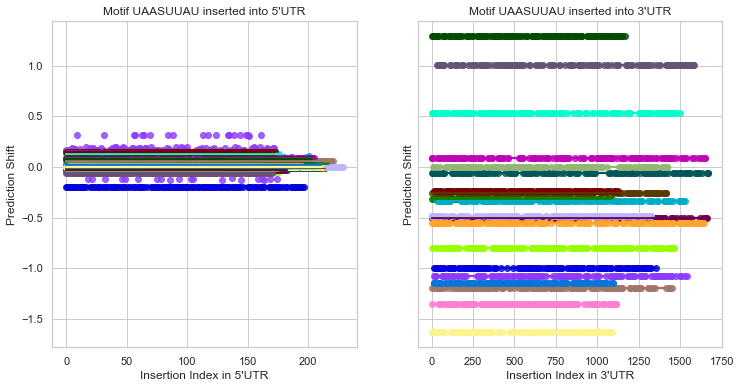

In [ ]:
# separate plots
sns.set_theme(style="whitegrid")

# Make an example dataset with y ~ x
y_utr5 = y_utr5_motif - y_utr5_clean
y_utr3 = y_utr3_motif - y_utr3_clean

d5 = {"Insertion Index in 5'UTR": insertion_indices_utr5, "Prediction Shift": y_utr5.squeeze(), "Sequence": sequence_ind}
d3 = {"Insertion Index in 3'UTR": insertion_indices_utr3, "Prediction Shift": y_utr3.squeeze(), "Sequence": sequence_ind}

df_utr5 = pd.DataFrame(data = d5)
df_utr3 = pd.DataFrame(data = d3)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,6))
# ax1.plot(df.x, df.y)
ax1.set_title("Motif UAASUUAU inserted into 5'UTR")
ax2.set_title("Motif UAASUUAU inserted into 3'UTR")

palette = sns.color_palette(cc.glasbey, n_colors=25)

hue_regplot(data=df_utr5, x="Insertion Index in 5'UTR", y="Prediction Shift", hue='Sequence', ax=ax1, palette = palette)
hue_regplot(data=df_utr3, x="Insertion Index in 3'UTR", y="Prediction Shift", hue='Sequence', ax=ax2, palette = palette)

plt.show()